In [1]:
import tensorflow as tf
import numpy as np
import math
from censai import PhysicalModel, RIMSharedUnet
from censai.definitions import DTYPE
from censai.models import SharedUnetModelv2, RayTracer
from censai.data.lenses_tng_v2 import decode_train, decode_physical_model_info, preprocess
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
import os, glob, time
from datetime import datetime
from tensorboard.plugins.hparams import api as hp
import random
    
    
RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize",
    "kappa_init",
    "source_init"
]
UNET_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "input_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "batch_norm",
    "dropout_rate",
    "kernel_l2_amp",
    "bias_l2_amp",
    "kernel_l1_amp",
    "bias_l1_amp",
    "activation",
    "alpha",
    "initializer",
    "gru_architecture"
]

In [2]:
# import tensorflow as tf
# import numpy as np
# import tensorflow_addons as tfa
# from censai.definitions import DTYPE
# from censai.utils import nulltape

# class PhysicalModel:
#     """
#     Physical model to be passed to RIM class at instantiation
#     """
#     def __init__(
#             self,
#             pixels,            # 512
#             psf_sigma=0.06,    # gaussian PSF
#             src_pixels=None,   # 128 for cosmos
#             kappa_pixels=None,
#             image_fov=7.68,
#             src_fov=3.0,
#             kappa_fov=7.68,
#             method="conv2d",
#             noise_rms=1,
#             raytracer=None
#     ):
#         print("My phys")
#         if src_pixels is None:
#             src_pixels = pixels  # assume src has the same shape
#         if kappa_pixels is None:
#             kappa_pixels = pixels
#         self.image_fov = image_fov
#         self.psf_sigma = psf_sigma
#         self.src_fov = src_fov
#         self.pixels = pixels
#         self.src_pixels = src_pixels
#         self.kappa_pixels = kappa_pixels
#         self.kappa_fov = kappa_fov
#         self.method = method
#         self.noise_rms = noise_rms
#         self.raytracer = raytracer
#         self.set_deflection_angle_vars()
#         self.PSF = self.psf_model()
#         if kappa_pixels != pixels:
#             self.kappa_to_image_grid = self._kappa_to_image_grid
#         else:
#             self.kappa_to_image_grid = tf.identity

#     def deflection_angle(self, kappa):
#         kappa = self.kappa_to_image_grid(kappa)  # resampling to shape of image
#         if self.method == "conv2d":
#             alpha_x = tf.nn.conv2d(kappa, self.xconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)
#             alpha_y = tf.nn.conv2d(kappa, self.yconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)

#         elif self.method == "unet":
#             alpha = self.raytracer(kappa)
#             alpha_x, alpha_y = tf.split(alpha, 2, axis=-1)

#         elif self.method == "fft":
#             """
#             The convolution using the Convolution Theorem.
#             Since we use FFT to justify this approach, we must zero pad the kernel and kappa map to transform 
#             a 'circular convolution' (assumed by our use of FFT) into an an 'acyclic convolution' 
#             (sum from m=0 to infinity).
            
#             To do that, we pad our signal with N-1 trailing zeros for each dimension. N = 2*pixels+1 since 
#             our kernel has this shape.
            
#             This approach has complexity O((4*pixels)^2 * log^2(4 * pixels)), and is precise to about rms=2e-5 of the 
#             true convolution for the deflection angles.
#             """
#             # pad the kernel and compute itf fourier transform
#             xconv_kernel = tf.image.pad_to_bounding_box(self.xconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
#             yconv_kernel = tf.image.pad_to_bounding_box(self.yconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
#             x_kernel_tilde = tf.signal.fft2d(tf.cast(-xconv_kernel[..., 0], tf.complex64))
#             y_kernel_tilde = tf.signal.fft2d(tf.cast(-yconv_kernel[..., 0], tf.complex64))

#             batch_size = kappa.shape[0]
#             alpha_x = tf.TensorArray(dtype=DTYPE, size=batch_size)
#             alpha_y = tf.TensorArray(dtype=DTYPE, size=batch_size)
#             for i in tf.range(batch_size):
#                 kap = tf.image.pad_to_bounding_box(kappa[i, ...],  # pad kappa one by one to save memory space
#                                                    offset_height=0,
#                                                    offset_width=0,
#                                                    target_width=4 * self.pixels + 1,
#                                                    target_height=4 * self.pixels + 1)
#                 kappa_tilde = tf.signal.fft2d(tf.cast(kap[..., 0], tf.complex64))
#                 alpha_x = alpha_x.write(index=i, value=tf.math.real(tf.signal.ifft2d(kappa_tilde * x_kernel_tilde)) * (self.dx_kap**2/np.pi))
#                 alpha_y = alpha_y.write(index=i, value=tf.math.real(tf.signal.ifft2d(kappa_tilde * y_kernel_tilde)) * (self.dx_kap**2/np.pi))
#             alpha_x = alpha_x.stack()[..., tf.newaxis]
#             alpha_x = tf.image.crop_to_bounding_box(alpha_x,
#                                                     offset_height=self.pixels,
#                                                     offset_width=self.pixels,
#                                                     target_width=self.pixels,
#                                                     target_height=self.pixels)
#             alpha_y = alpha_y.stack()[..., tf.newaxis]
#             alpha_y = tf.image.crop_to_bounding_box(alpha_y,
#                                                     offset_height=self.pixels,
#                                                     offset_width=self.pixels,
#                                                     target_width=self.pixels,
#                                                     target_height=self.pixels)
#         else:
#             raise ValueError(f"{self.method} is not in [conv2d, unet, fft]")
#         return alpha_x, alpha_y

#     def log_likelihood(self, source, kappa, y_true, outer_tape=nulltape):
#         y_pred = self.forward(source, kappa)
#         prior = tf.square(tf.reduce_sum(y_pred, axis=(1, 2, 3)) - tf.reduce_sum(y_true, axis=(1, 2, 3)))
#         mask = tf.cast(y_true > 1e-2, DTYPE)
# #         with outer_tape.stop_recording():
# #             lam = self.lagrange_multiplier(y_true, y_pred)
#         return 0.5 * tf.reduce_sum(mask * (y_pred - y_true) ** 2 / self.noise_rms ** 2, axis=(1, 2, 3)) + 0.1 * prior

# #     def log_likelihoodv2(self, source, kappa, y_true, outer_tape=nulltape):
# #         y_pred = self.forward(source, kappa)
# #         with outer_tape.stop_recording():
# #             lam = self.masked_lagrange_multiplier(y_true, y_pred)
# #         return 0.5 * tf.reduce_mean((lam * y_pred - y_true) ** 2 / self.noise_rms ** 2, axis=(1, 2, 3)), lam

#     @staticmethod
#     def lagrange_multiplier(y_true, y_pred):
#         return tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3), keepdims=True) / tf.reduce_sum(y_true**2, axis=(1, 2, 3), keepdims=True)

#     @staticmethod
#     def masked_lagrange_multiplier(y_true, y_pred):
#         mask = tf.cast(y_true > 0.1, DTYPE)
#         return tf.reduce_sum(mask * y_true * y_pred, axis=(1, 2, 3), keepdims=True) / tf.reduce_sum(mask * y_pred**2, axis=(1, 2, 3), keepdims=True)

#     def forward(self, source, kappa):
#         im = self.lens_source(source, kappa)
#         im = self.convolve_with_psf(im)
#         return im

#     def noisy_forward(self, source, kappa, noise_rms):
#         im = self.lens_source(source, kappa)
#         noise = tf.random.normal(im.shape, mean=0, stddev=noise_rms)
#         out = self.convolve_with_psf(im)  # convolve before adding noise, otherwise it correlates the noise
#         out = out + noise
#         return out

#     def lens_source(self, source, kappa):
#         alpha_x, alpha_y = self.deflection_angle(kappa)
#         x_src = self.ximage - alpha_x
#         y_src = self.yimage - alpha_y
#         x_src_pix, y_src_pix = self.src_coord_to_pix(x_src, y_src)
#         warp = tf.concat([x_src_pix, y_src_pix], axis=-1)
#         im = tfa.image.resampler(source, warp)  # bilinear interpolation of source on warp grid
#         return im

#     def lens_source_func(self, kappa, xs=0., ys=0., es=0., w=0.1):
#         alpha_x, alpha_y = self.deflection_angle(kappa)
#         # lens equation
#         beta1 = self.ximage - alpha_x
#         beta2 = self.yimage - alpha_y
#         # sample intensity directly from the functional form
#         rho_sq = (beta1 - xs) ** 2 / (1 - es) + (beta2 - ys) ** 2 * (1 - es)
#         lens = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
#         lens = self.convolve_with_psf(lens)
#         return lens

#     def lens_source_func_given_alpha(self, alpha, xs=0., ys=0., es=0., w=0.1):
#         alpha1, alpha2 = tf.split(alpha, 2, axis=-1)
#         # lens equation
#         beta1 = self.ximage - alpha1
#         beta2 = self.yimage - alpha2
#         # sample intensity directly from the functional form
#         rho_sq = (beta1 - xs) ** 2 / (1 - es) + (beta2 - ys) ** 2 * (1 - es)
#         lens = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
#         lens = self.convolve_with_psf(lens)
#         return lens


#     def src_coord_to_pix(self, x, y):
#         dx = self.src_fov / (self.src_pixels - 1)
#         xmin = -0.5 * self.src_fov
#         ymin = -0.5 * self.src_fov
#         i_coord = (x - xmin) / dx
#         j_coord = (y - ymin) / dx
#         return i_coord, j_coord

#     def kap_coord_to_pix(self, x, y):
#         dx = self.kappa_fov / (self.kappa_pixels - 1)
#         xmin = -0.5 * self.kappa_fov
#         ymin = -0.5 * self.kappa_fov
#         i_coord = (x - xmin) / dx
#         j_coord = (y - ymin) / dx
#         return i_coord, j_coord

#     def _kappa_to_image_grid(self, kappa):
#         batch_size = kappa.shape[0]
#         x_coord, y_coord = self.kap_coord_to_pix(self.xkappa, self.ykappa)
#         warp = tf.concat([x_coord, y_coord], axis=-1)
#         warp = tf.tile(warp, [batch_size, 1, 1, 1])  # make sure warp has same batch size has kappa
#         kappa = tfa.image.resampler(kappa, warp)
#         return kappa

#     def set_deflection_angle_vars(self):
#         self.dx_kap = self.kappa_fov / (self.pixels - 1)  # dx on image grid

#         # Convolution kernel
#         x = tf.cast(tf.linspace(-1, 1, 2 * self.pixels + 1), dtype=DTYPE) * self.kappa_fov
#         xx, yy = tf.meshgrid(x, x)
#         rho = xx**2 + yy**2
#         xconv_kernel = -self._safe_divide(xx, rho)
#         yconv_kernel = -self._safe_divide(yy, rho)
#         # reshape to [filter_height, filter_width, in_channels, out_channels]
#         self.xconv_kernel = tf.cast(xconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)
#         self.yconv_kernel = tf.cast(yconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)

#         # coordinates for image
#         x = tf.cast(tf.linspace(-1, 1, self.pixels), dtype=DTYPE) * self.image_fov / 2
#         xx, yy = tf.meshgrid(x, x)
#         # reshape for broadcast to [batch_size, pixels, pixels, 1]
#         self.ximage = tf.cast(xx[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
#         self.yimage = tf.cast(yy[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

#         # Coordinates for kappa
#         xkappa = tf.cast(tf.linspace(-1, 1, self.pixels), dtype=DTYPE) * self.kappa_fov / 2
#         xkappa, ykappa = tf.meshgrid(xkappa, xkappa)
#         self.xkappa = tf.cast(xkappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
#         self.ykappa = tf.cast(ykappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)


#     @staticmethod
#     def _safe_divide(num, denominator):
#         out = np.zeros_like(num)
#         out[denominator != 0] = num[denominator != 0] / denominator[denominator != 0]
#         return out

#     def psf_model(self):
#         pixel_scale = self.image_fov / self.pixels
#         cutout_size = int(10 * self.psf_sigma / pixel_scale)
#         r_squared = self.ximage**2 + self.yimage**2
#         psf = tf.math.exp(-0.5 * r_squared / self.psf_sigma**2)
#         psf = tf.image.crop_to_bounding_box(psf,
#                                             offset_height=self.pixels//2 - cutout_size//2,
#                                             offset_width=self.pixels//2 - cutout_size//2,
#                                             target_width=cutout_size,
#                                             target_height=cutout_size)
#         psf /= tf.reduce_sum(psf)
#         psf = tf.reshape(psf, shape=[cutout_size, cutout_size, 1, 1])
#         return psf

#     def convolve_with_psf(self, images):
#         convolved_images = tf.nn.conv2d(images, self.PSF, [1, 1, 1, 1], padding="SAME")
#         return convolved_images


In [4]:
import tensorflow as tf
from censai.models import SharedUnetModel
from censai.definitions import logkappa_normalization, log_10, DTYPE, logit, lrelu4p
# from censai import PhysicalModel
from censai.utils import nulltape


class RIMSharedUnet:
    """
    Architecture has only 1 Unet. Source and kappa information are stacked along channel dimension.

    There are 2 intended structures:
        1. Kappa has a larger shape than Source tensor:
            1 - Use a half-strided convolution to upsample the output of the Unet
            3 - Use bilinear interpolation to upsample
        2. Kappa and Source have the same tensor shape -> Identity layer

    In any case, we use the Source shape for the Unet
    """
    def __init__(
            self,
            physical_model: PhysicalModel,
            unet: SharedUnetModel,
            steps: int,
            adam=True,
            kappalog=True,
            kappa_normalize=False,
            source_link="relu",
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-8,
            kappa_init=1e-1,
            source_init=1e-3
    ):
        print("My RIM")
        self.physical_model = physical_model
        self.kappa_pixels = physical_model.kappa_pixels
        self.source_pixels = physical_model.src_pixels
        self.unet = unet
        self.steps = steps
        self.adam = adam
        self.kappalog = kappalog
        self._source_link_func = source_link
        self.kappa_normalize = kappa_normalize
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self._kappa_init = kappa_init
        self._source_init = source_init

        if self.kappalog:
            if self.kappa_normalize:
                self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: logkappa_normalization(log_10(x), forward=True))
                self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**(logkappa_normalization(x, forward=False)))
            else:
                self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: log_10(x))
                self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**x)
        else:
            self.kappa_link = tf.identity
            self.kappa_inverse_link = tf.identity

        if self._source_link_func == "exp":
            self.source_inverse_link = tf.keras.layers.Lambda(lambda x: tf.math.log(x + 1e-3))
            self.source_link = tf.keras.layers.Lambda(lambda x: tf.math.exp(x))
        elif self._source_link_func == "identity":
            self.source_inverse_link = tf.identity
            self.source_link = tf.identity
        elif self._source_link_func == "relu":
            self.source_inverse_link = tf.identity
            self.source_link = tf.nn.relu
        elif self._source_link_func == "sigmoid":
            self.source_inverse_link = logit
            self.source_link = tf.nn.sigmoid
        elif self._source_link_func == "lrelu4p":
            self.source_inverse_link = tf.identity
            self.source_link = lrelu4p
        else:
            raise NotImplementedError(f"{source_link} not in ['exp', 'identity', 'relu', 'leaky_relu', 'lrelu4p', 'sigmoid']")

        if adam:
            self.grad_update = self.adam_grad_update
        else:
            self.grad_update = lambda x, y, t: (x, y)

    def adam_grad_update(self, grad1, grad2, time_step):
        time_step = tf.cast(time_step, DTYPE)
        self._grad_mean1 = self.beta_1 * self._grad_mean1 + (1 - self.beta_1) * grad1
        self._grad_var1 = self.beta_2 * self._grad_var1 + (1 - self.beta_2) * tf.square(grad1)
        self._grad_mean2 = self.beta_1 * self._grad_mean2 + (1 - self.beta_1) * grad2
        self._grad_var2 = self.beta_2 * self._grad_var2 + (1 - self.beta_2) * tf.square(grad2)
        # for grad update, unbias the moments
        m_hat1 = self._grad_mean1 / (1 - self.beta_1 ** (time_step + 1))
        v_hat1 = self._grad_var1 / (1 - self.beta_2 ** (time_step + 1))
        m_hat2 = self._grad_mean2 / (1 - self.beta_1 ** (time_step + 1))
        v_hat2 = self._grad_var2 / (1 - self.beta_2 ** (time_step + 1))
        return m_hat1 / (tf.sqrt(v_hat1) + self.epsilon), m_hat2 / (tf.sqrt(v_hat2) + self.epsilon)

    def initial_states(self, batch_size):
        # Define initial guess in physical space, then apply inverse link function to bring them in prediction space
        source_init = self.source_inverse_link(
            tf.ones(shape=(batch_size, self.source_pixels, self.source_pixels, 1)) * self._source_init)
        kappa_init = self.kappa_inverse_link(
            tf.ones(shape=(batch_size, self.kappa_pixels, self.kappa_pixels, 1)) * self._kappa_init)
        states = self.unet.init_hidden_states(self.source_pixels, batch_size)

        # reset adam gradients
        self._grad_mean1 = tf.zeros_like(source_init, dtype=DTYPE)
        self._grad_var1 = tf.zeros_like(source_init, dtype=DTYPE)
        self._grad_mean2 = tf.zeros_like(kappa_init, dtype=DTYPE)
        self._grad_var2 = tf.zeros_like(kappa_init, dtype=DTYPE)
        return source_init, kappa_init, states

    def time_step(self, source, kappa, source_grad, kappa_grad, states, scope=None):
        source, kappa, states = self.unet(source, kappa, source_grad, kappa_grad, states)
        return source, kappa, states

    def __call__(self, lensed_image, outer_tape=nulltape):
        return self.call(lensed_image, outer_tape)

#     def call(self, lensed_image, outer_tape=nulltape):
#         """
#         Used in training. Return linked kappa and source maps.
#         """
#         mask = tf.cast(lensed_image > 0.5, tf.float32)
#         batch_size = lensed_image.shape[0]
#         source, kappa, states = self.initial_states(batch_size)

#         source_series = tf.TensorArray(DTYPE, size=self.steps)
#         kappa_series = tf.TensorArray(DTYPE, size=self.steps)
#         chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
#         for current_step in tf.range(self.steps):
#             with outer_tape.stop_recording():
#                 with tf.GradientTape() as g:
#                     g.watch(source)
#                     g.watch(kappa)
#                     log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
#                     cost = tf.reduce_mean(log_likelihood)
#                 source_grad, kappa_grad = g.gradient(cost, [source, kappa])
#                 source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
#             source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
#             source_series = source_series.write(index=current_step, value=source/lam)
#             kappa_series = kappa_series.write(index=current_step, value=kappa)
#             if current_step > 0:
#                 chi_squared_series = chi_squared_series.write(index=current_step-1, value=log_likelihood)
#         # last step score
#         log_likelihood, lam = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
#         chi_squared_series = chi_squared_series.write(index=self.steps-1, value=log_likelihood)
#         return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()
    
    def call(self, lensed_image, kappa, outer_tape=nulltape): # Yashar test, just ignore kappa pred and use label
        """
        Used in training. Return linked kappa and source maps.
        """
#         mask = tf.cast(lensed_image > self.physical_model.noise_rms * 2, tf.float32)
        batch_size = lensed_image.shape[0]
        source, _, states = self.initial_states(batch_size)

        source_series = tf.TensorArray(DTYPE, size=self.steps)
        kappa_series = tf.TensorArray(DTYPE, size=self.steps)
        chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
        for current_step in tf.range(self.steps):
            with outer_tape.stop_recording():
                with tf.GradientTape() as g:
                    g.watch(source)
                    g.watch(kappa)
                    y_pred = self.physical_model.forward(source=self.source_link(source), kappa=kappa)
                    log_likelihood = 0.5 * tf.reduce_sum(tf.square(y_pred - lensed_image) / self.physical_model.noise_rms**2, axis=(1, 2, 3))
#                     log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=kappa, outer_tape=g)
                    cost = tf.reduce_mean(log_likelihood)
                source_grad, kappa_grad = g.gradient(cost, [source, kappa])
                source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
            source, _, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
            source_series = source_series.write(index=current_step, value=source)
            kappa_series = kappa_series.write(index=current_step, value=kappa)
            if current_step > 0:
                chi_squared_series = chi_squared_series.write(index=current_step-1, value=log_likelihood)
        # last step score
        log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=kappa)
        chi_squared_series = chi_squared_series.write(index=self.steps-1, value=log_likelihood)
        return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()

    @tf.function
    def call_function(self, lensed_image):
        """
        Used in training. Return linked kappa and source maps.

        This method use the tensorflow function autograph decorator, which enables us to use tf.gradients instead
        of creating a tape at each time steps. Potentially faster, but also memory hungry because for loop is unrolled
        when the graph is created.
        """
        batch_size = lensed_image.shape[0]
        source, kappa, states = self.initial_states(batch_size)

        source_series = tf.TensorArray(DTYPE, size=self.steps)
        kappa_series = tf.TensorArray(DTYPE, size=self.steps)
        chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
        for current_step in tf.range(self.steps):
            log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
            cost = tf.reduce_mean(log_likelihood)
            source_grad, kappa_grad = tf.gradients(cost, [source, kappa])
            source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
            source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
            source_series = source_series.write(index=current_step, value=source)
            kappa_series = kappa_series.write(index=current_step, value=kappa)
            if current_step > 0:
                chi_squared_series = chi_squared_series.write(index=current_step-1, value=log_likelihood)
        # last step score
        log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
        chi_squared_series = chi_squared_series.write(index=self.steps-1, value=log_likelihood)
        return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()

    def predict(self, lensed_image):
        """
        Used in inference. Return physical kappa and source maps.
        """
        batch_size = lensed_image.shape[0]
        source, kappa, states = self.initial_states(batch_size)

        source_series = tf.TensorArray(DTYPE, size=self.steps)
        kappa_series = tf.TensorArray(DTYPE, size=self.steps)
        chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
        for current_step in range(self.steps):
            with tf.GradientTape() as g:
                g.watch(source)
                g.watch(kappa)
                log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
                cost = tf.reduce_mean(log_likelihood)
            source_grad, kappa_grad = g.gradient(cost, [source, kappa])
            source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
            source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
            source_series = source_series.write(index=current_step, value=self.source_link(source)/lam)
            kappa_series = kappa_series.write(index=current_step, value=self.kappa_link(kappa))
            if current_step > 0:
                chi_squared_series = chi_squared_series.write(index=current_step - 1, value=log_likelihood)
        # last step score
        log_likelihood, lam = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source),
                                                            kappa=self.kappa_link(kappa))
        chi_squared_series = chi_squared_series.write(index=self.steps - 1, value=log_likelihood)
        return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()  # stack along 0-th dimension

    def cost_function(self, lensed_image, source, kappa, outer_tape=nulltape, reduction=True):
        """

        Args:
            lensed_image: Batch of lensed images
            source: Batch of source images
            kappa: Batch of kappa maps
            reduction: Whether or not to reduce the batch dimension in computing the loss or not

        Returns: The average loss over pixels, time steps and (if reduction=True) batch size.

        """
        source_series, kappa_series, chi_squared = self.call(lensed_image, outer_tape=outer_tape)
        source_cost = tf.reduce_sum(tf.square(source_series - self.source_inverse_link(source)), axis=0) / self.steps
        kappa_cost = tf.reduce_sum(tf.square(kappa_series - self.kappa_inverse_link(kappa)), axis=0) / self.steps
        chi = tf.reduce_sum(chi_squared, axis=0) / self.steps

        if reduction:
            return tf.reduce_mean(source_cost) + tf.reduce_mean(kappa_cost), tf.reduce_mean(chi)
        else:
            return tf.reduce_mean(source_cost, axis=(1, 2, 3)) + tf.reduce_mean(kappa_cost, axis=(1, 2, 3)), chi



In [5]:
def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for physical_params in dataset.map(decode_physical_model_info):
        break
    # preprocessing
    dataset = dataset.map(decode_train)#.map(preprocess)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file)
#     train_dataset = dataset.shuffle(buffer_size=args.buffer_size).take(math.floor(args.train_split * args.total_items))\
#         .batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items))\
        .batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items))\
        .take(math.ceil((1 - args.train_split) * args.total_items)).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    # train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    # val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    # with STRATEGY.scope():  # Replicate ops accross gpus
    if args.raytracer is not None:
        raytracer = RayTracer(**raytracer_hparams)
        # load last checkpoint in the checkpoint directory
        checkpoint = tf.train.Checkpoint(net=raytracer)
        manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
    else:
        raytracer = None
    phys = PhysicalModel(
        pixels=physical_params["pixels"].numpy(),
        kappa_pixels=physical_params["kappa pixels"].numpy(),
        src_pixels=physical_params["src pixels"].numpy(),
        image_fov=physical_params["image fov"].numpy(),
        kappa_fov=physical_params["kappa fov"].numpy(),
        src_fov=physical_params["source fov"].numpy(),
        method=args.forward_method,
        noise_rms=physical_params["noise rms"].numpy(),
        raytracer=raytracer,
        psf_sigma=physical_params["psf sigma"].numpy()
    )

    unet = SharedUnetModelv2(
        filters=args.filters,
        filter_scaling=args.filter_scaling,
        kernel_size=args.kernel_size,
        layers=args.layers,
        block_conv_layers=args.block_conv_layers,
        strides=args.strides,
        bottleneck_kernel_size=args.bottleneck_kernel_size,
        resampling_kernel_size=args.resampling_kernel_size,
        input_kernel_size=args.input_kernel_size,
        gru_kernel_size=args.gru_kernel_size,
        upsampling_interpolation=args.upsampling_interpolation,
        kernel_l2_amp=args.kernel_l2_amp,
        bias_l2_amp=args.bias_l2_amp,
        kernel_l1_amp=args.kernel_l1_amp,
        bias_l1_amp=args.bias_l1_amp,
        activation=args.activation,
        initializer=args.initializer,
        batch_norm=args.batch_norm,
        dropout_rate=args.dropout_rate
    )
    rim = RIMSharedUnet(
        physical_model=phys,
        unet=unet,
        steps=args.steps,
        adam=args.adam,
        kappalog=args.kappalog,
        source_link=args.source_link,
        kappa_normalize=args.kappa_normalize,
        kappa_init=args.kappa_init,
        source_init=args.source_init
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
    # weights for time steps in the loss function
    if args.time_weights == "uniform":
        wt = tf.ones(shape=(args.steps), dtype=DTYPE) / args.steps
    elif args.time_weights == "linear":
        wt = 2 * (tf.range(args.steps, dtype=DTYPE) + 1) / args.steps / (args.steps + 1)
    elif args.time_weights == "quadratic":
        wt = 6 * (tf.range(args.steps, dtype=DTYPE) + 1)**2 / args.steps / (args.steps + 1) / (2 * args.steps + 1)
    else:
        raise ValueError("time_weights must be in ['uniform', 'linear', 'quadratic']")
#     wt = (tf.range(args.steps, dtype=DTYPE) + 1)**4
#     wt /= tf.reduce_sum(wt)
    wt = wt[..., tf.newaxis]  # [steps, batch]
    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id + "_" + args.logname if args.logname is not None else args.model_id
        model_id = args.model_id
    elif args.logname is not None:
        logname = args.logname
        model_id = logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
        model_id = logname
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        old_checkpoints_dir = os.path.join(args.model_dir, model_id)  # in case they differ we load model from a different directory
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "unet_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
            with open(os.path.join(checkpoints_dir, "rim_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RIM_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, old_checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
        if old_checkpoints_dir != checkpoints_dir:  # save progress in another directory.
            checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
    else:
        save_checkpoint = False
    # =================================================================================================================

#     def train_step(X, source, kappa):
#         with tf.GradientTape() as tape:
#             tape.watch(rim.unet.trainable_variables)
#             if args.unroll_time_steps:
#                 source_series, kappa_series, chi_squared = rim.call_function(X)
#             else:
#                 source_series, kappa_series, chi_squared = rim.call(X, outer_tape=tape)
#             # mean over image residuals
#             source_cost1 = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
#             kappa_cost1 = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
#             # weighted mean over time steps
#             source_cost = tf.reduce_sum(wt * source_cost1, axis=0)
#             kappa_cost = tf.reduce_sum(wt * kappa_cost1, axis=0)
#             # final cost is mean over global batch size
#             cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
#         gradient = tape.gradient(cost, rim.unet.trainable_variables)
#         if args.clipping:
#             gradient = [tf.clip_by_norm(grad, 1.) for grad in gradient]
#         optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
#         # Update metrics with "converged" score
#         chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
#         source_cost = tf.reduce_sum(source_cost1[-1]) / args.batch_size
#         kappa_cost = tf.reduce_sum(kappa_cost1[-1]) / args.batch_size
#         return cost, chi_squared, source_cost, kappa_cost

    def train_step(X, source, kappa): # Yashar test
        with tf.GradientTape() as tape:
            tape.watch(rim.unet.trainable_variables)
            source_series, kappa_series, chi_squared = rim.call(X, kappa, outer_tape=tape)
            # mean over image residuals
            source_cost1 = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
            kappa_cost1 = tf.reduce_mean(tf.square(kappa_series - kappa), axis=(2, 3, 4))
            # weighted mean over time steps
            source_cost = tf.reduce_sum(wt * source_cost1, axis=0)
            kappa_cost = tf.reduce_sum(wt * kappa_cost1, axis=0)
            # final cost is mean over global batch size
            cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        gradient = tape.gradient(cost, rim.unet.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_norm(grad, 1.) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
        # Update metrics with "converged" score
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
        source_cost = tf.reduce_sum(source_cost1[-1]) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost1[-1]) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost



    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    epoch_source_loss = tf.metrics.Mean()
    epoch_kappa_loss = tf.metrics.Mean()
    val_chi_squared = tf.metrics.Mean()
    val_source_loss = tf.metrics.Mean()
    val_kappa_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_chi_squared": [],
        "train_source_cost": [],
        "train_kappa_cost": [],
        "val_cost": [],
        "val_chi_squared": [],
        "val_source_cost": [],
        "val_kappa_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "step": [],
        "wall_time": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time*3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_chi_squared.reset_states()
        epoch_source_loss.reset_states()
        epoch_kappa_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, (X, source, kappa) in enumerate(train_dataset):
                start = time.time()
                cost, chi_squared, source_cost, kappa_cost = train_step(X, source, kappa)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                epoch_source_loss.update_state([source_cost])
                epoch_kappa_loss.update_state([kappa_cost])
                step += 1

            val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
            val_chi_sq = val_chi_squared.result().numpy()
            train_chi_sq = epoch_chi_squared.result().numpy()
            val_kappa_cost = val_kappa_loss.result().numpy()
            train_kappa_cost = epoch_kappa_loss.result().numpy()
            val_source_cost = val_source_loss.result().numpy()
            train_source_cost = epoch_source_loss.result().numpy()
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| lr {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s"
              f"| kappa cost {train_kappa_cost:.2e} | source cost {train_source_cost:.2e} | chi sq {train_chi_sq:.2e}")
        history["train_cost"].append(train_cost)
#         history["val_cost"].append(val_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["train_chi_squared"].append(train_chi_sq)
#         history["val_chi_squared"].append(val_chi_sq)
        history["time_per_step"].append(time_per_step.result().numpy())
        history["train_kappa_cost"].append(train_kappa_cost)
        history["train_source_cost"].append(train_source_cost)
#         history["val_kappa_cost"].append(val_kappa_cost)
#         history["val_source_cost"].append(val_source_cost)
        history["step"].append(step)
        history["wall_time"].append(time.time() - global_start)

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return rim, phys, train_dataset, val_dataset



In [6]:
from argparse import ArgumentParser
import json
parser = ArgumentParser()

parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",              default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",               action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",           action="store_true")
parser.add_argument("--kappa_normalize",    action="store_true")
parser.add_argument("--source_link",        default="identity",             help="One of 'exp', 'source', 'relu' or 'identity' (default).")
parser.add_argument("--kappa_init",         default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",        default=1e-3,   type=float,     help="Initial value of source for RIM")

# Shared Unet params
parser.add_argument("--filters",                                    default=32,     type=int)
parser.add_argument("--filter_scaling",                             default=1,      type=float)
parser.add_argument("--kernel_size",                                default=3,      type=int)
parser.add_argument("--layers",                                     default=2,      type=int)
parser.add_argument("--block_conv_layers",                          default=2,      type=int)
parser.add_argument("--strides",                                    default=2,      type=int)
parser.add_argument("--bottleneck_kernel_size",                     default=None,   type=int)
parser.add_argument("--bottleneck_filters",                         default=None,   type=int)
parser.add_argument("--resampling_kernel_size",                     default=None,   type=int)
parser.add_argument("--input_kernel_size",                          default=11,     type=int)
parser.add_argument("--gru_kernel_size",                            default=None,   type=int)
parser.add_argument("--upsampling_interpolation",                   action="store_true")
parser.add_argument("--batch_norm",                                 action="store_true")
parser.add_argument("--dropout_rate",                               default=None,   type=float)
parser.add_argument("--kernel_l2_amp",                              default=0,      type=float)
parser.add_argument("--bias_l2_amp",                                default=0,      type=float)
parser.add_argument("--kernel_l1_amp",                              default=0,      type=float)
parser.add_argument("--bias_l1_amp",                                default=0,      type=float)
parser.add_argument("--activation",                                 default="leaky_relu")
parser.add_argument("--alpha",                                      default=0.1,    type=float)
parser.add_argument("--initializer",                                default="glorot_normal")
parser.add_argument("--gru_architecture",                           default="concat",   help="'concat': architecture of Laurence. 'plus': original RNN architecture")


# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files at a given moment.")
parser.add_argument("--buffer_size",            default=1000,   type=int,       help="Buffer size for shuffling at each epoch.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",            action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",               default=np.inf, type=float,     help="Time allowed for the training, in hours.")
parser.add_argument("--time_weights",           default="uniform",              help="uniform: w_t=1 for all t, linear: w_t~t, quadratic: w_t~t^2")
parser.add_argument("--unroll_time_steps",      action="store_true")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMUnet512",          help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,    nargs="+",     help="A json filepath that will override every command line parameters. "
                                                                             "Useful for reproducibility")

_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [8]:
import sys
sys.argv = ['']
# model_id = "RIMSU128hst_interactive_21-11-05_15-40-22"
args = parser.parse_args(
  f"--datasets {os.getenv('CENSAI_PATH')}/data/lenses128hst_TNG_VAE_200k_control_validated_train "\
#   f"--model_id={model_id} "\
  f"--forward_method=fft "\
#   f"--forward_method=unet "\
#   f"--raytracer={os.getenv('CENSAI_PATH')}/models/RT128_512_grid4_010_FS2.0_K3_F16_42_lr0.0001_ds50000_211006132142 "\
  f"--compression_type=GZIP "\
  f"--optimizer=RMSProp "\
  f"--epochs=100 "\
  f"--max_time=1 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=1 "\
  f"--decay_steps=1000 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=200 "\
  f"--tolerance=0.01 "\
  f"--batch_size=1 "\
  f"--train_split=1 "\
  f"--total_items=10 "\
  f"--block_length=1 "\
  f"--buffer_size=100 "\
  f"--steps=5 "\
  f"--time_weights=uniform "\
#   f"--adam "\
  f"--kappalog "\
  f"--source_link=relu "\
  f"--filters=32 "\
  f"--filter_scaling=2 "\
  f"--kernel_size=3 "\
  f"--input_kernel_size=11 "\
  f"--layers=4 "\
  f"--block_conv_layers=1 "\
  "--kappa_init=1e-1 "\
  "--source_init=0 "\
  f"--resampling_kernel_size=3 "\
#   f"--gru_kernel_size=3 "\
#   f"--batch_norm "\
#   f"--dropout=0.1 "\
#   f"--upsampling_interpolation "\
#   f"--kernel_l2_amp=1e-4 "\
#   f"--bias_l2_amp=1e-4 "\
#   f"--kernel_l1_amp=1e-3 "\
#   f"--bias_l1_amp=1e-3 "\
  f"--activation=tanh "\
#   f"--alpha=0.3 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIMSU128hst_interactive "\
  f"--track_train "\
  f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=3 "\
  f"--seed=42 "\
  f"--n_residuals=0 "\
   "--track_train".split(" ")
#   f"--json_override {os.getenv('CENSAI_PATH')}/models/{model_id}/unet_hparams.json {os.getenv('CENSAI_PATH')}/models/{model_id}/rim_hparams.json".split()
)
if args.json_override is not None:
    if isinstance(args.json_override, list):
        files = args.json_override
    else:
        files = [args.json_override,]
    for file in files:
        with open(file, "r") as f:
            json_override = json.load(f)
        args_dict = vars(args)
        args_dict.update(json_override)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

My RIM
epoch 0 | train loss 7.220e-02 | val loss 0.000e+00 | lr 1.00e-04 | time per step 4.20e-01 s| kappa cost 0.00e+00 | source cost 2.09e-01 | chi sq 2.90e+02
Saved checkpoint for step 2: /home/aadam/scratch/Censai/models/RIMSU128hst_interactive_21-11-05_17-09-35/ckpt-1
epoch 1 | train loss 2.729e-02 | val loss 0.000e+00 | lr 1.00e-04 | time per step 4.05e-01 s| kappa cost 0.00e+00 | source cost 7.42e-02 | chi sq 4.82e+01
epoch 2 | train loss 1.869e-02 | val loss 0.000e+00 | lr 1.00e-04 | time per step 4.06e-01 s| kappa cost 0.00e+00 | source cost 4.90e-02 | chi sq 3.05e+01
epoch 3 | train loss 1.397e-02 | val loss 0.000e+00 | lr 1.00e-04 | time per step 4.23e-01 s| kappa cost 0.00e+00 | source cost 3.52e-02 | chi sq 2.21e+01
epoch 4 | train loss 1.264e-02 | val loss 0.000e+00 | lr 1.00e-04 | time per step 4.07e-01 s| kappa cost 0.00e+00 | source cost 3.09e-02 | chi sq 2.32e+01
epoch 5 | train loss 8.698e-03 | val loss 0.000e+00 | lr 1.00e-04 | time per step 4.08e-01 s| kappa cost 0

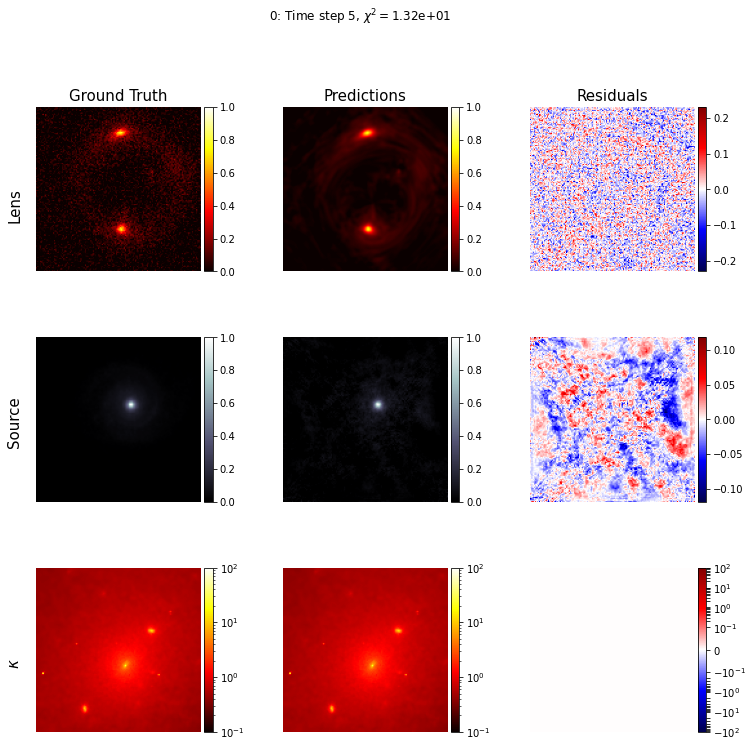

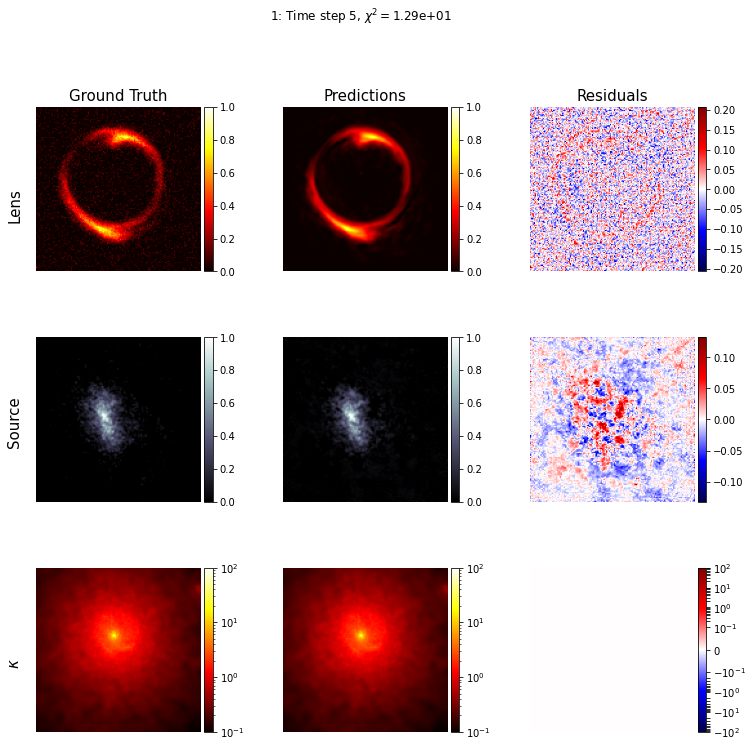

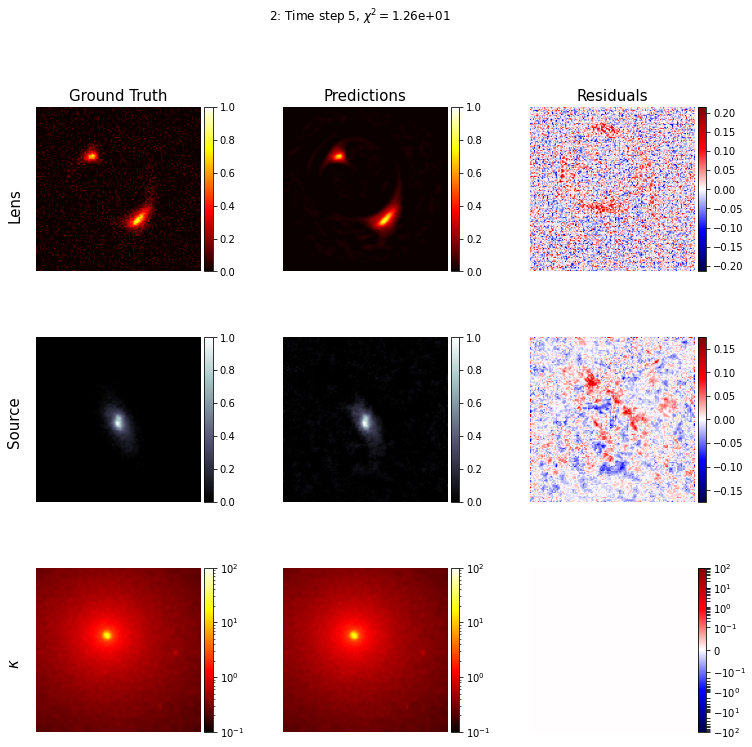

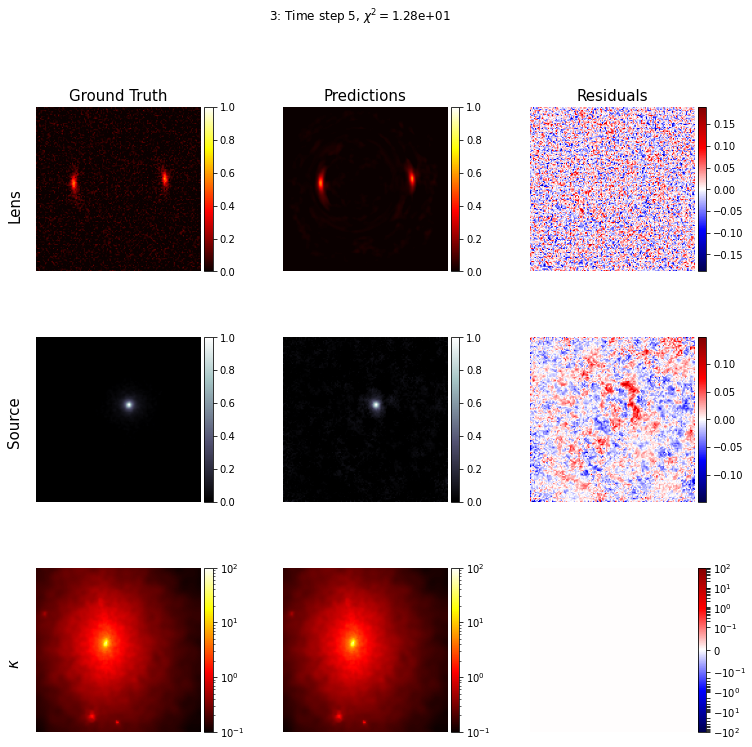

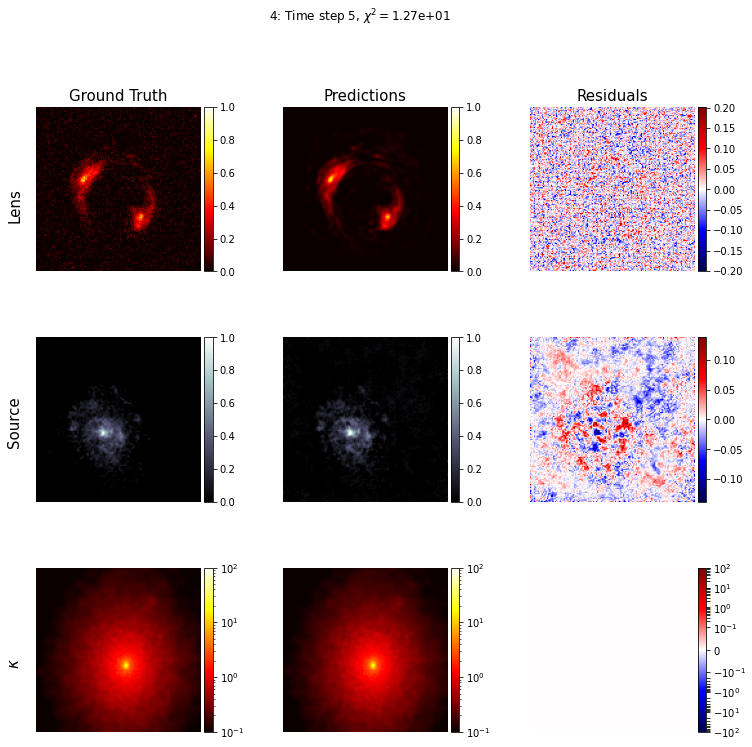

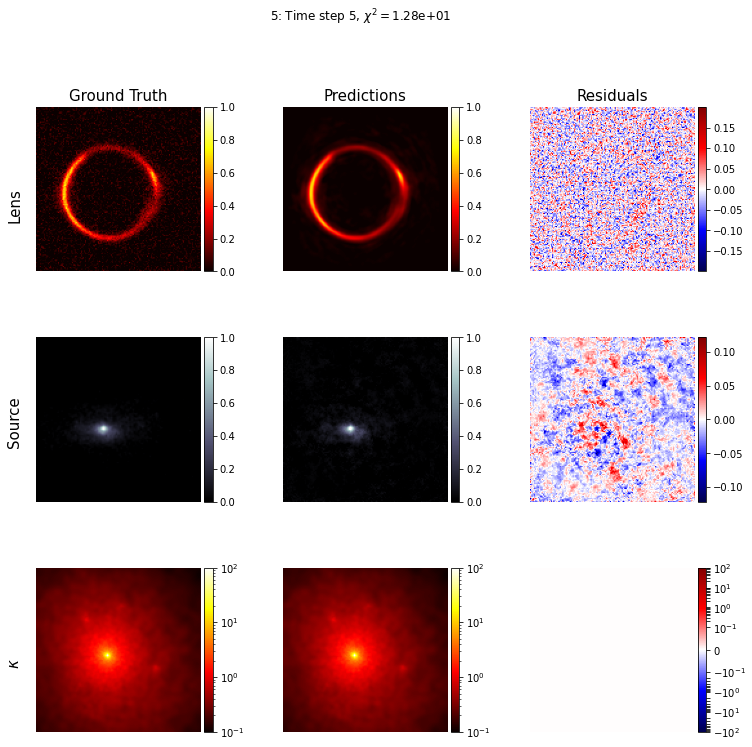

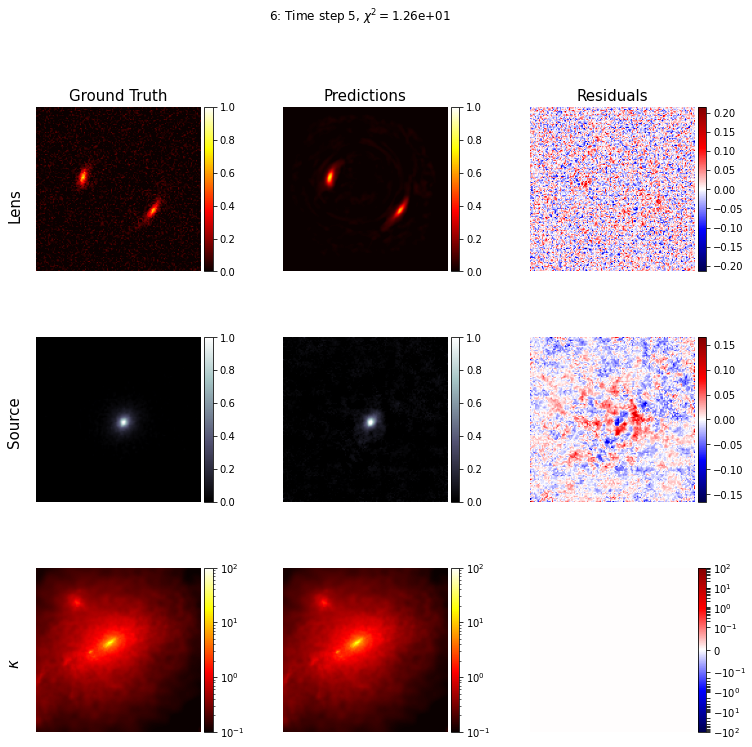

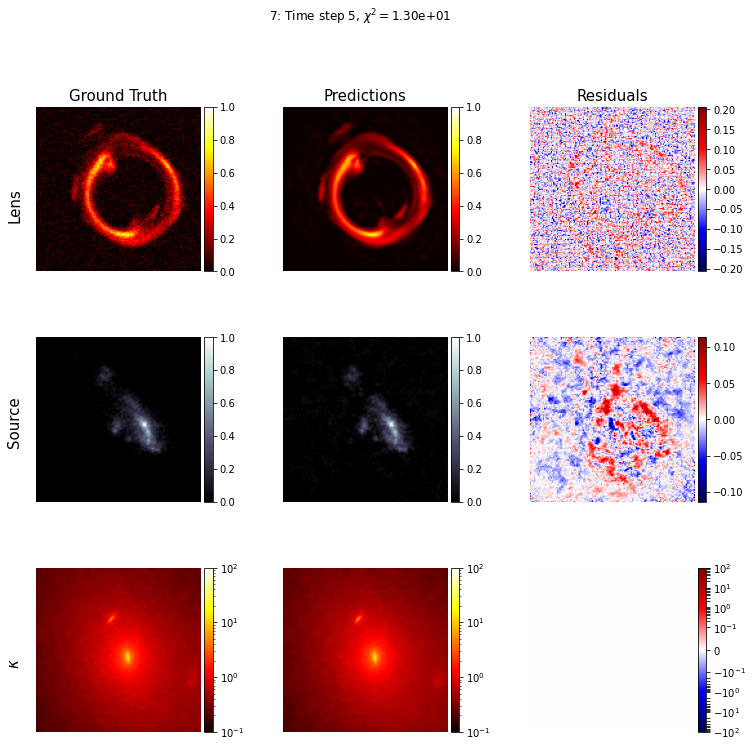

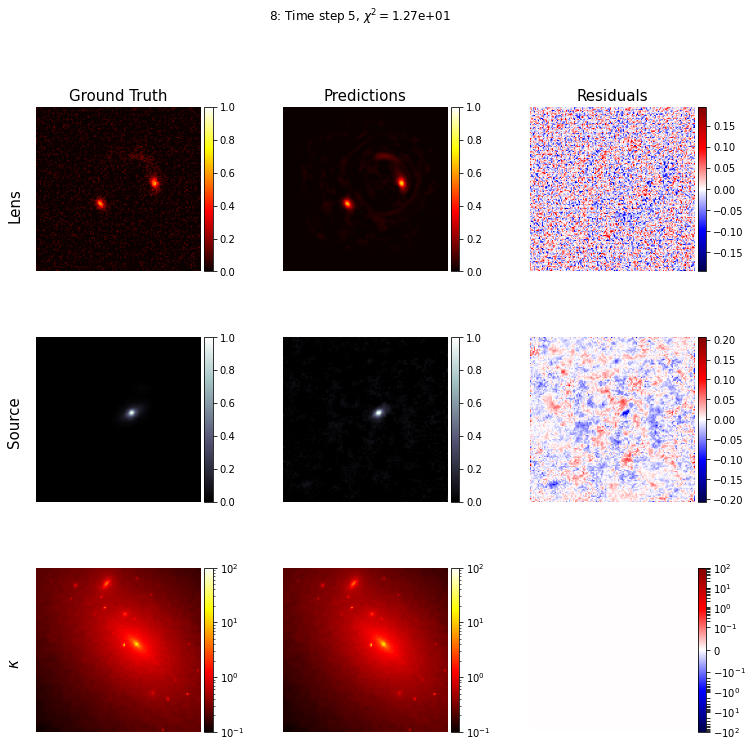

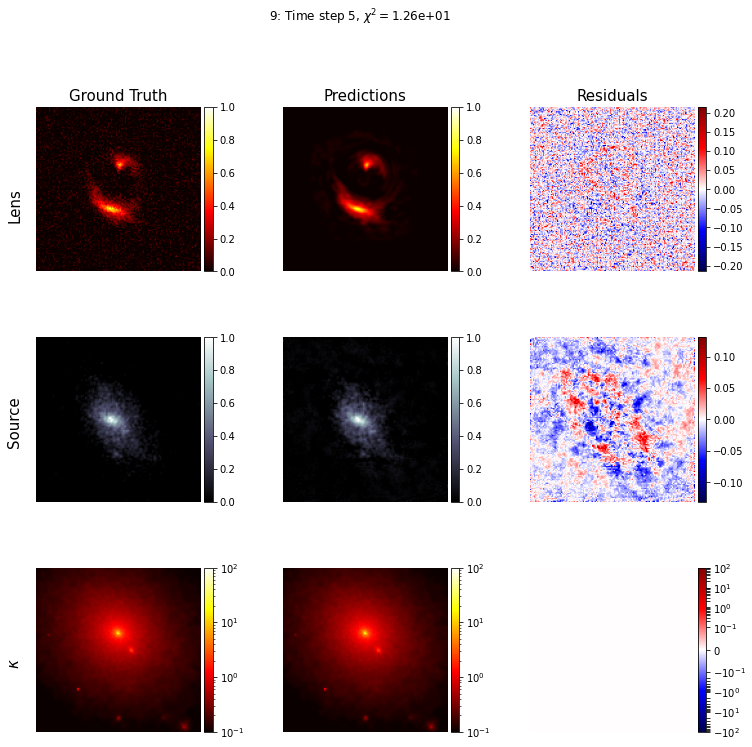

In [10]:
# phys.forward_method = "fft"
j = 0
for batch, (lens_true, source, kappa) in enumerate(train_dataset):
#     source_pred, kappa_pred, chi_squared = rim.predict(lens_true)
    lens_true =phys.noisy_forward(source, kappa, noise_rms=0.05)
    source_pred, kappa_pred, chi_squared = rim.call(lens_true, kappa)
    lens_pred = phys.forward(source_pred[-1], kappa)
    for i in range(args.batch_size):
        fig = residual_plot(lens_true[i], source[i], kappa[i], lens_pred[i], source_pred[-1][i], kappa_pred[-1][i], chi_squared[-1][i])
        fig.suptitle(fr"{batch}: Time step {args.steps}, $\chi^2 = ${chi_squared[-1][i]:.2e}")
    if j == 10: break
    j += 1

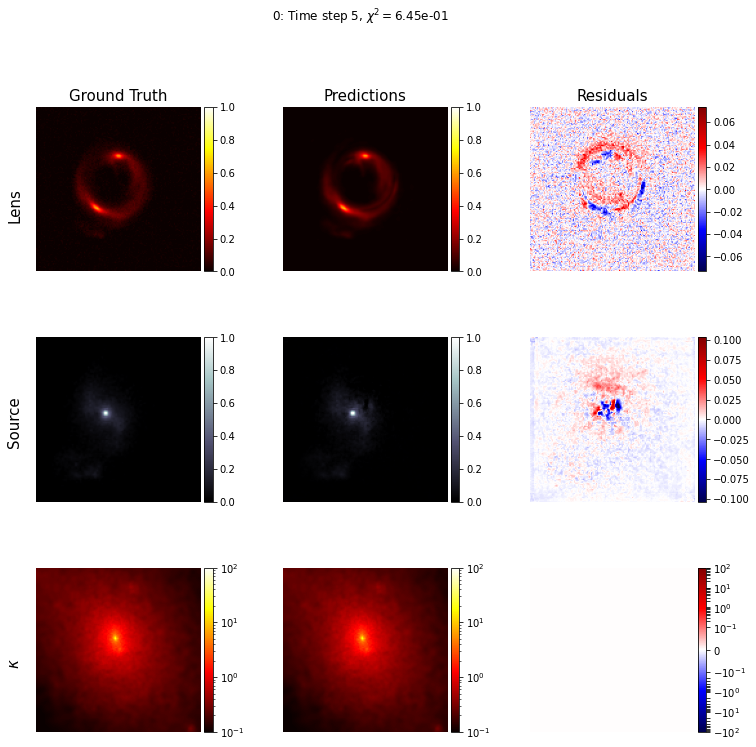

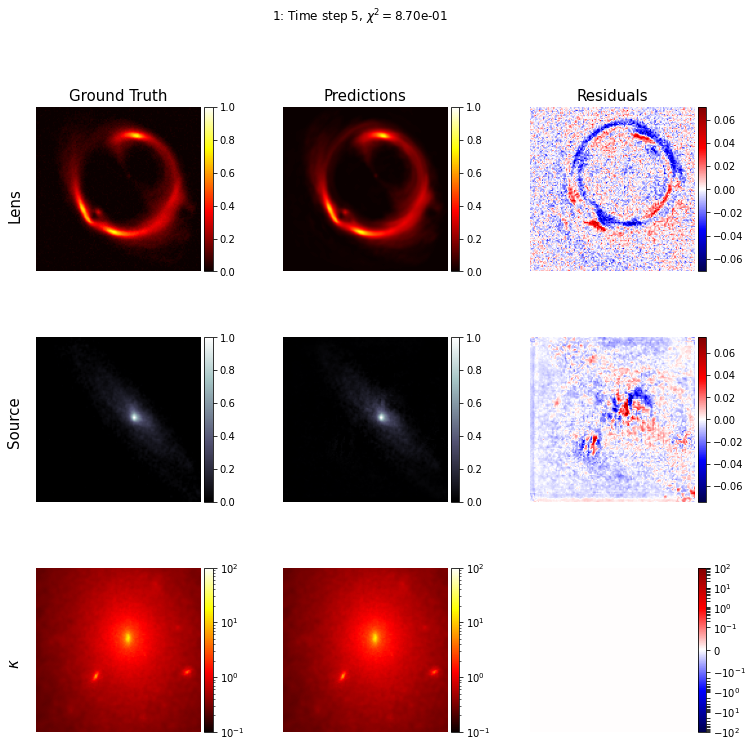

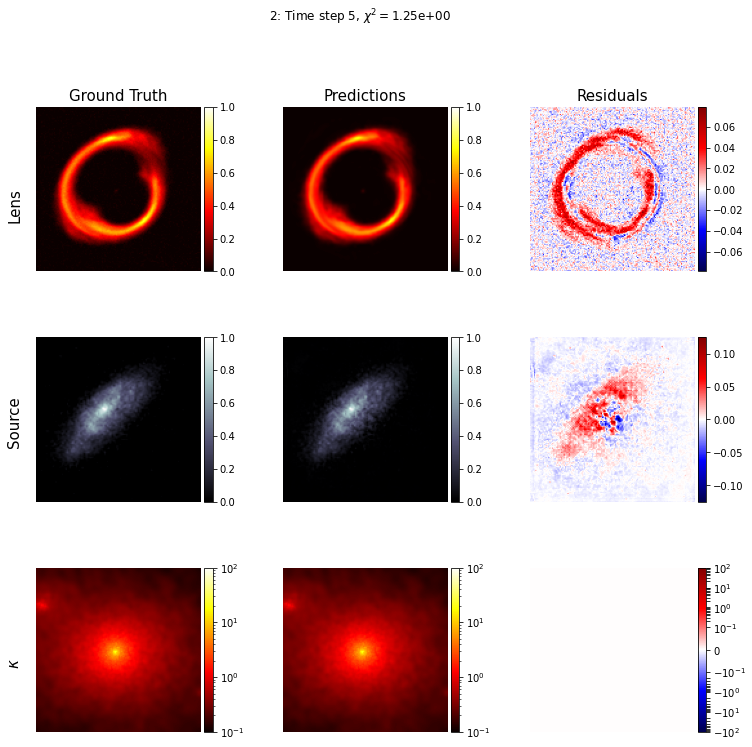

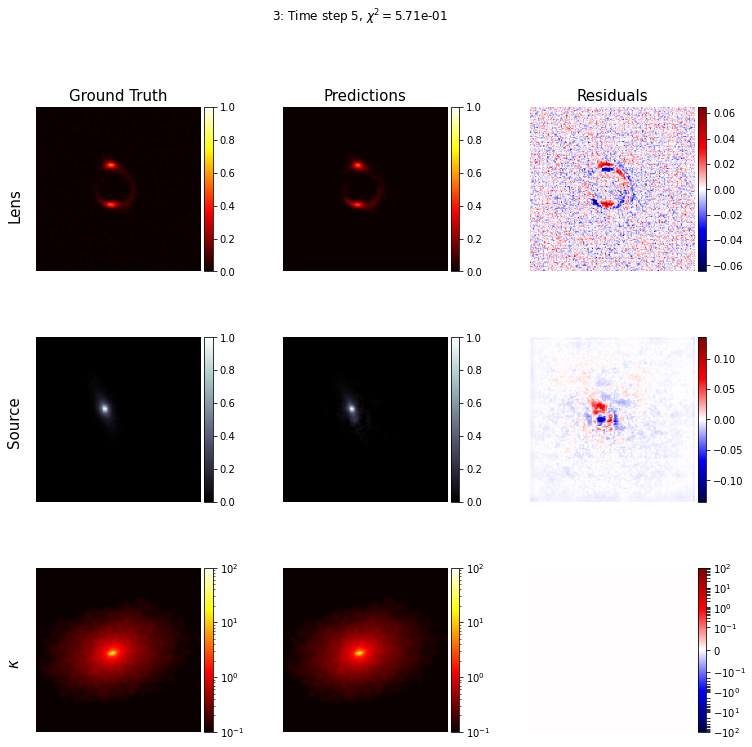

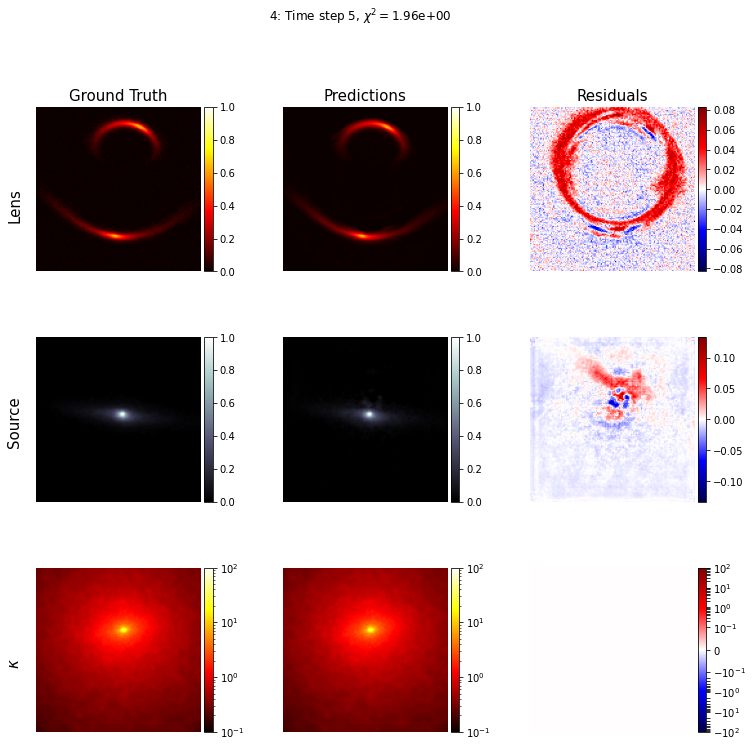

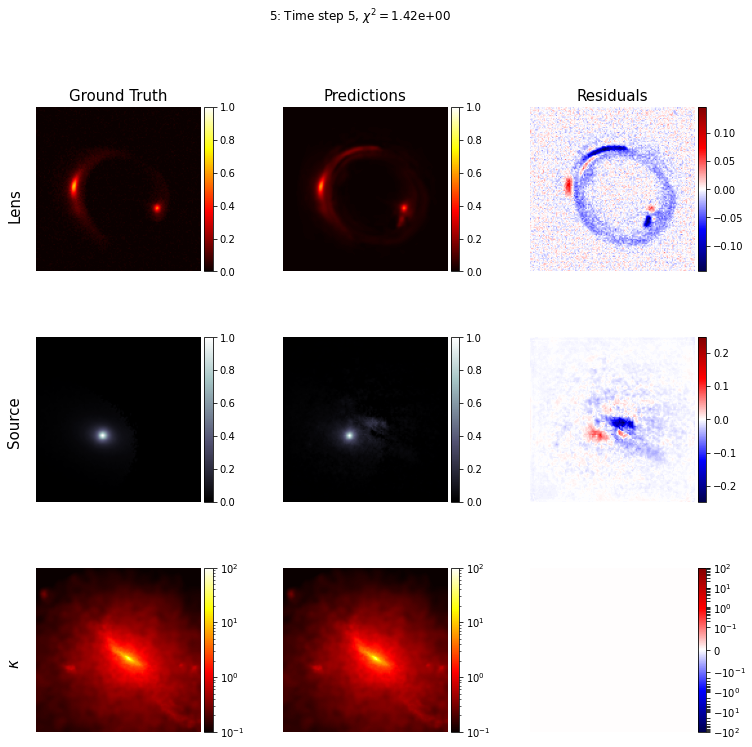

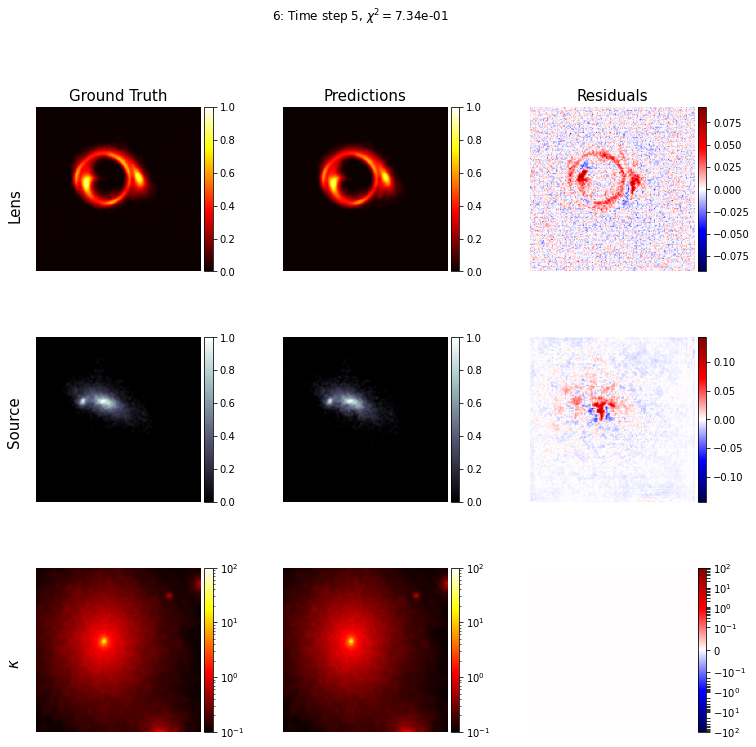

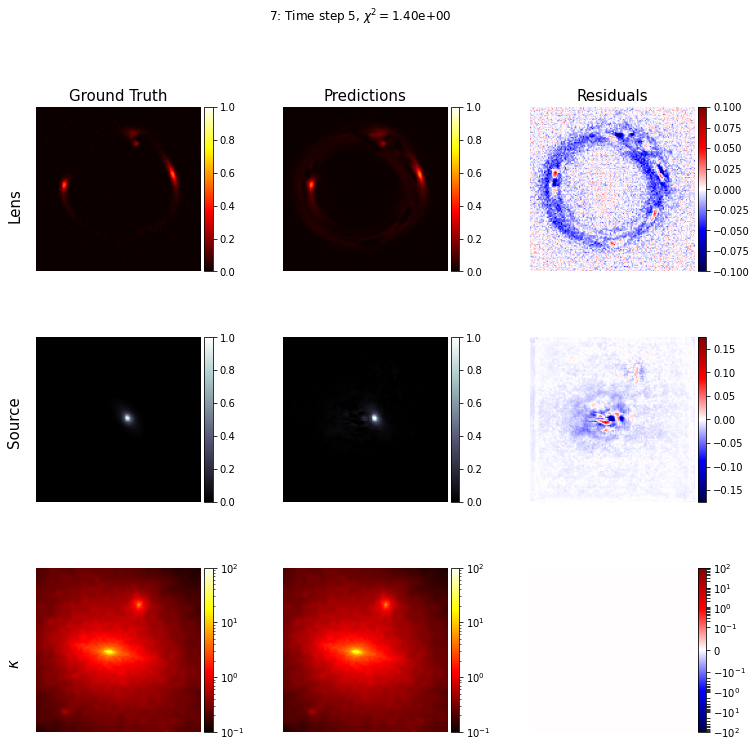

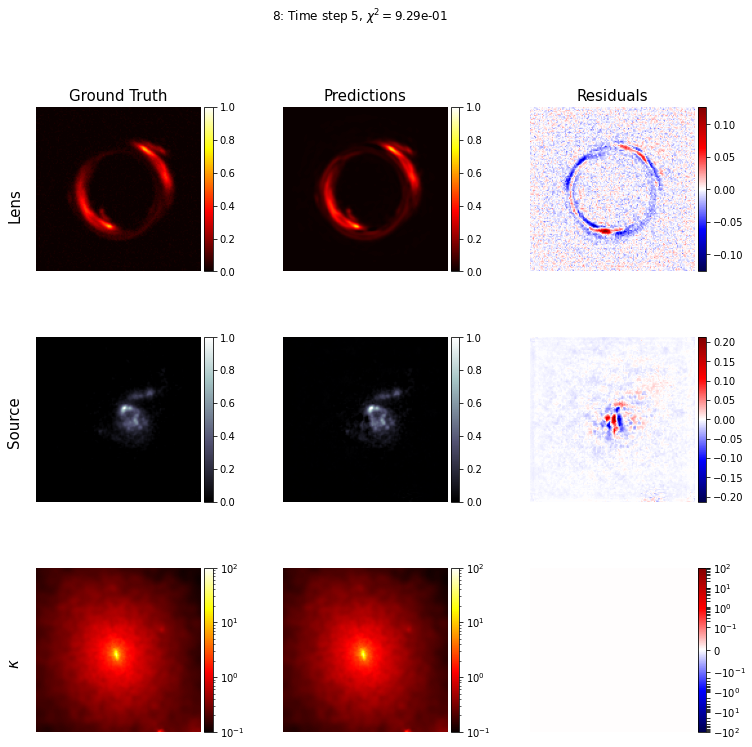

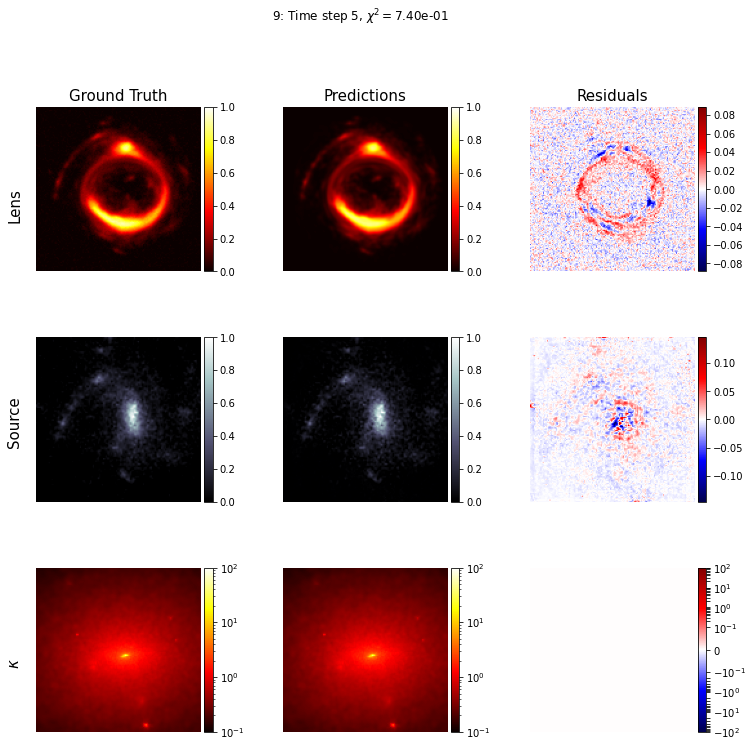

In [25]:
# phys.forward_method = "fft"
j = 0
for batch, (lens_true, source, kappa) in enumerate(train_dataset):
#     source_pred, kappa_pred, chi_squared = rim.predict(lens_true)
#     lens_true =phys.noisy_forward(source, kappa, noise_rms=0.05)
    source_pred, kappa_pred, chi_squared = rim.call(lens_true, kappa)
    lens_pred = phys.forward(source_pred[-1], kappa)
    for i in range(args.batch_size):
        fig = residual_plot(lens_true[i], source[i], kappa[i], lens_pred[i], source_pred[-1][i], kappa_pred[-1][i], chi_squared[-1][i])
        fig.suptitle(fr"{batch}: Time step {args.steps}, $\chi^2 = ${chi_squared[-1][i]:.2e}")
    if j == 10: break
    j += 1

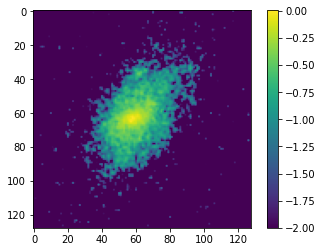

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(np.log10(source[0, ..., 0] + 1e-2))
plt.colorbar()
